In [1]:
import sys
sys.path.append('/home/scarab5/Desktop/Pose-Estimation-for-Sensor-Calibration')

sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')


import numpy as np
import os
import glob
# import pickle

# import rospy
from ur_msgs.srv import JointTrajectory, EndPose, JointStates

from matplotlib import pyplot as plt
from utils_realsense import RealSenseSensor

sys.path.append('/usr/lib/python2.7/dist-packages')
from realrobot_utils import *
from axxb_solver import *

# from calibration_helper import *
# from custom_geometric_transform import *
# from transformations import quaternion_matrix
# from transformations import quaternion_from_matrix
# from transformations import rotation_matrix

# from helpers import Tools
# EPS=0.00001
from Pose_Estimation_Class import *

In [2]:
realsense = RealSenseSensor("025222072234")
K_rs = realsense._color_intrinsics
D_rs = 0

In [3]:
planUR5 = rospy.ServiceProxy('plan_robot_arm', JointTrajectory)
moveUR5 = rospy.ServiceProxy('move_robot_arm', JointTrajectory)
getEEFPose = rospy.ServiceProxy('get_eef_pose', EndPose)
getJointStates = rospy.ServiceProxy('get_joint_states', JointStates)

In [4]:
rospy.wait_for_service('plan_robot_arm')
rospy.wait_for_service('move_robot_arm')
rospy.wait_for_service('get_eef_pose')
rospy.wait_for_service('get_joint_states')

In [16]:
ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
ROBOT_INIT_POS = [0.0, -0.3, 0.65]
ROBOT_INIT_ROTATION = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

In [6]:
def get_joint_states():
    joints_Str = getJointStates().joint_states.replace('(', '').replace(')', '').split(', ')
    joints = [float(j) for j in joints_Str]
    return joints

In [7]:
def get_eef_pose():
    pose = getEEFPose().eef_pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

In [8]:
def get_view(goal_pos=None, quat=[1, 0, 0, 0], grasp=0.0, show_img=False):
    # quat: xyzw
    if goal_pos is not None:
        plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat, 1-grasp)
        if len(plans.plan.points)<=1:
            print("Failed planning to the goal.")
            current_pos, current_quat = get_eef_pose()
            subgoal_pos = (np.array(goal_pos) + np.array(current_pos))/2
            print('current:', current_pos)
            print('sub goal:', subgoal_pos)
            print('goal:', goal_pos)
            sub_plans = moveUR5(ARM_JOINT_NAME, None, subgoal_pos, current_quat)
            rospy.sleep(1.5)
            plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat)
            if len(plans.plan.points)<=1:
                print("Failed planning to the sub-goal.")
                return False
    rospy.sleep(0.5)
    color, depth = realsense.frames(spatial=True, hole_filling=True, temporal=True)
    if show_img:
        plt.imshow(color)
        plt.show()
    return color, depth

In [9]:
CHECKERBOARD = (6, 9)
def get_cam_theta_p(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    return R_vec_cam_to_chess, p_cam_to_chess

def get_cam_R_T(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    R_cam_to_chess, _ = cv2.Rodrigues(R_vec_cam_to_chess)
    T_cam_to_chess = form_T(R_cam_to_chess, p_cam_to_chess)
    return R_cam_to_chess, T_cam_to_chess

In [10]:
getEEFPose()

eef_pose: 
  position: 
    x: -0.0008168594614527753
    y: -0.30099128403408826
    z: 0.6472136381050193
  orientation: 
    x: 0.999976345711629
    y: 0.0046751213633714
    z: -0.002713041784971526
    w: -0.004253311854024221

In [11]:
getJointStates()

joint_states: "(-1.953851048146383, -1.87636644044985, 1.2271537780761719, -0.9149664084063929,\
  \ 4.719136714935303, 2.744056224822998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"

In [140]:
img, _ = get_view(ROBOT_INIT_POS, grasp=0.0) # grasp=1.0
R, T = get_cam_R_T(img)
print(np.linalg.inv(T))

error: OpenCV(4.2.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:754: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [90]:
T_eef_to_rs = np.load('rs_extrinsic.npy')

In [ ]:
X_MIN = -0.5
X_MAX = 0.5
Y_MIN = -0.85
Y_MAX = -0.3
Z_MIN = 0.18
Z_MAX = 0.8

In [169]:
X_WS_MIN = -0.3
X_WS_MAX = 0.3
Y_WS_MIN = -0.75
Y_WS_MAX = -0.35
Z_WS_MIN = 0.19
Z_WS_MAX = 0.25
ROBOT_WS_INIT = [0, -0.5, 0.65]

In [170]:
ROBOT_WS_INIT

[0, -0.5, 0.65]

In [171]:
pos = ROBOT_WS_INIT #[0.0, -0.5, 0.6]
quat = [1, 0, 0, 0]
grasp = 1.0
_ = moveUR5(ARM_JOINT_NAME, None, pos, quat, 1-grasp)

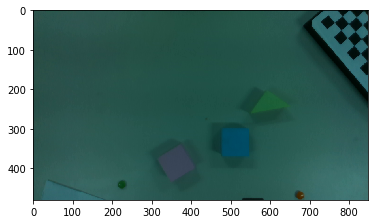

In [172]:
color, depth = get_view(None, show_img=True)

In [173]:
def pixel2pose(depth, robot_pose, goal_pixel):
    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, robot_pose)
    T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))    
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    print(goal_position)

In [174]:
print(pixel2pose(depth, ROBOT_WS_INIT, np.array([420,0])))
print(pixel2pose(depth, ROBOT_WS_INIT, np.array([420,479])))

[ 0.04677166 -0.85078092  0.2       ]
None
[ 0.05330331 -0.34255276  0.2       ]
None


In [165]:
img, _ = get_view(None)
# get_cam_R_T(img)
pos, quat = get_eef_pose()
print([np.round(p, 3) for p in pos])
print([np.round(q, 4) for q in quat])

[-0.0, -0.45, 0.65]
[1.0, -0.0001, -0.0, 0.0]


In [121]:
calib_positions = np.array([
    [0.0, -0.3, 0.65],
    [0.282, -0.413, 0.606],
    [0.249, -0.217, 0.567],
    [-0.193, -0.278, 0.495],
    [-0.249, -0.528, 0.45]
])
# xyzw quaternion
calib_quaternions = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.9917, 0.0041, -0.1246, 0.0321],
    [0.9626, 0.1529, -0.205, 0.09],
    [0.9697, -0.1399, 0.191, 0.0606],
    [0.9685, -0.1086, 0.2076, -0.0849]
])

calib_positions = np.array([
        [0.0, -0.3, 0.65],
        [0.0, -0.49, 0.59],
        [0.25, -0.41, 0.61],
        [0.26, -0.19, 0.61],
        [-0.09, -0.39, 0.58]
    ])
calib_quaternions = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.990, 0.004, 0.004, -0.139],
        [0.994, 0.005, -0.112, -0.014],
        [0.976, 0.028, -0.109, 0.187],
        [0.994, 0.068, 0.083, 0.002]
    ])

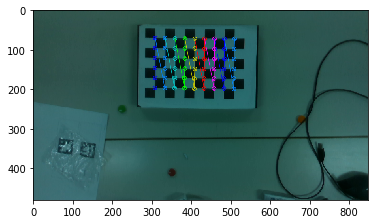

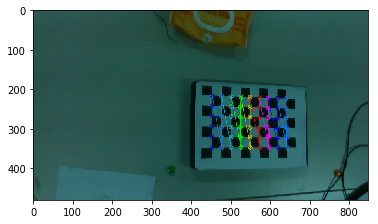

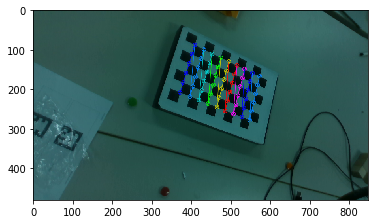

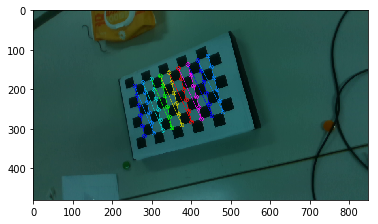

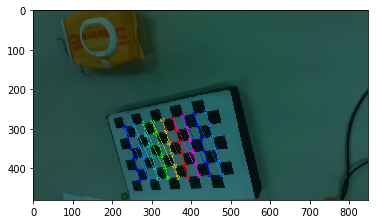

In [122]:
T_realsense = []
T_ur5 = []

for p, q in zip(calib_positions, calib_quaternions):
    img, _ = get_view(p, q)
    R, T_cam_to_chess = get_cam_R_T(img)
    T_chess_to_cam = np.linalg.inv(T_cam_to_chess)
    
    q_wxyz = [q[3], q[0], q[1], q[2]]
    T_base_to_eef = form_T(quaternion_matrix(q_wxyz)[:3, :3], p)
    
    T_realsense.append(T_chess_to_cam)
    T_ur5.append(T_base_to_eef)
    rospy.sleep(1.0)

img, _ = get_view(ROBOT_INIT_POS)

In [123]:
T_realsense

[array([[ 0.01134394, -0.99829726, -0.05721788, -0.08090302],
        [ 0.99992801,  0.01154904, -0.0032552 ,  0.01762673],
        [ 0.00391047, -0.05717684,  0.99835641, -0.61181975],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.01321181, -0.9968872 ,  0.07772623, -0.01637817],
        [ 0.97557636,  0.0298967 ,  0.21761654, -0.25252489],
        [-0.2192629 ,  0.07295276,  0.97293457, -0.55587776],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.26484072, -0.9368465 ,  0.22842509, -0.21266978],
        [ 0.8728621 ,  0.33358662,  0.35613441, -0.24301883],
        [-0.40984283,  0.10506471,  0.90608513, -0.51551353],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.2370484 , -0.95788813,  0.1620444 , -0.12505959],
        [ 0.88880298, -0.28117372, -0.36189859,  0.23797887],
        [ 0.392221  ,  0.05823806,  0.91802561, -0.47121535],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [124]:
# form A, B matrix
A = []
B = []

for i, Ti in enumerate(T_ur5):
    for j, Tj in enumerate(T_ur5):
        if i==j: continue
        A.append(np.linalg.inv(Ti).dot(Tj))
        
for i, Ti in enumerate(T_realsense):
    for j, Tj in enumerate(T_realsense):
        if i==j: continue
        B.append(np.linalg.inv(Ti).dot(Tj))
        #A.append(Ti.dot(np.linalg.inv(Tj)))

A = np.array(A).transpose([1,2,0])
B = np.array(B).transpose([1,2,0])

+ Simultaneous Robot/World and Tool/Flange Calibration:    
Implementation of Shah, Mili. "Solving the robot-world/hand-eye calibration problem using the Kronecker product." 
Journal of Mechanisms and Robotics 5.3 (2013): 031007.

Batch_Processing solvesfor  X and Y in AX=YB from a set of (A,B) paired measurements.
(Ai,Bi) are absolute pose measurements with known correspondance       
A: (4x4xn) 
X: (4x4): unknown
Y: (4x4): unknown
B: (4x4xn) 
n number of measurements

+ EKF,IEKF solves for AX=XB from a set of (Ai,Bi) relative pose measurements with known correspondance.
so3 representation was used to represent the state of rotation.  

In [125]:
def get_error(T_rs_to_eef):
    error = 0
    for i in range(A.shape[-1]):
        err = np.linalg.norm(A[:,:,i].dot(T_rs_to_eef) - T_rs_to_eef.dot(B[:,:,i]))
        error += err
    return error

In [166]:
#UKF
ukf=UKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    ukf.Update(AA,BB)

theta=np.linalg.norm(ukf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=ukf.x[0:3]/np.linalg.norm(ukf.x[:3])
euler_ukf=Tools.mat2euler(Tools.vec2rotmat(theta, k))
print('.....UKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_ukf)*180/np.pi)
print('Translation:', ukf.x[3:])
print('------------------------------')
T_eef_to_rs = form_T(Tools.vec2rotmat(theta, k), ukf.x[3:])
print(T_eef_to_rs)

print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

.....UKF Results
Euler: [ 31.06217106  58.87316716 -42.00559215]
Translation: [ 0.17086549 -0.1301615   0.73910183]
------------------------------
[[ 0.44281001 -0.26672148  0.85602509  0.17086549]
 [-0.1073067   0.93210241  0.34593404 -0.1301615 ]
 [-0.89017109 -0.24504028  0.38412327  0.73910183]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [-0.17789345  0.52563512  0.0479866   0.83051726]
Euler(degree): [ 31.06217106  58.87316716 -42.00559215]
------------------------------
Error: 24.707492718990718


In [167]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_eef_to_rs = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_eef_to_rs)

print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

IEKF Results
Euler: [ 81.38164934  62.9557728  -93.24758676]
Translation: [ 0.28146034 -0.15275315  0.85991277]
------------------------------
[[ 0.06813444 -0.44954411  0.89065582  0.28146034]
 [-0.18926329  0.8706955   0.45394795 -0.15275315]
 [-0.97955965 -0.19949794 -0.02575785  0.85991277]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [-0.23621853  0.67607672  0.09409066  0.69156925]
Euler(degree): [ 81.38164934  62.9557728  -93.24758676]
------------------------------
Error: 24.132292155260213


In [169]:
T_eef_to_rs = LeastSquaresAXXB(A.transpose([2, 0, 1]), B.transpose([2, 0, 1]), verbose=True)

print(T_eef_to_rs)
print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

RotX: [[-0.99874401  0.0130596   0.04837204]
 [-0.01343033 -0.99988282 -0.00734716]
 [ 0.04827042 -0.00798758  0.99880237]]
tX: [0.01598357 0.08912667 0.02184209]
[[-0.99874401  0.0130596   0.04837204  0.01598357]
 [-0.01343033 -0.99988282 -0.00734716  0.08912667]
 [ 0.04827042 -0.00798758  0.99880237  0.02184209]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [ 0.02416838 -0.00383492  0.9996786  -0.00662461]
Euler(degree): [-179.2508418     2.77259549    0.42145838]
------------------------------
Error: 1.1710812704636475


In [170]:
np.save('rs_extrinsic.npy', T_eef_to_rs)

In [164]:
A[:,:,0].dot(T_eef_to_rs)

array([[-0.97983298, -0.00150323, -0.1998126 ,  0.29353252],
       [-0.01014733, -0.99830713,  0.05727053,  0.20335077],
       [-0.19956043,  0.05814312,  0.97815899,  0.06348984],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [165]:
T_eef_to_rs.dot(B[:,:,0])

array([[-9.84214562e-01,  3.76807762e-04, -1.76978965e-01,
         2.86468710e-01],
       [-2.20678457e-02, -9.92454586e-01,  1.20610551e-01,
         1.63077468e-01],
       [-1.75598138e-01,  1.22612205e-01,  9.76796571e-01,
         6.23875256e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [163]:
T_test = np.eye(4)
T_test[:3,:3] = Rotation.from_euler('zx', [180, 180], degrees=True).as_matrix()
print(T_test)
get_error(T_test)

[[-1.00000000e+00 -1.22464680e-16  0.00000000e+00  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 1.49975978e-32 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


30.005158398839626

<IPython.core.display.Javascript object>


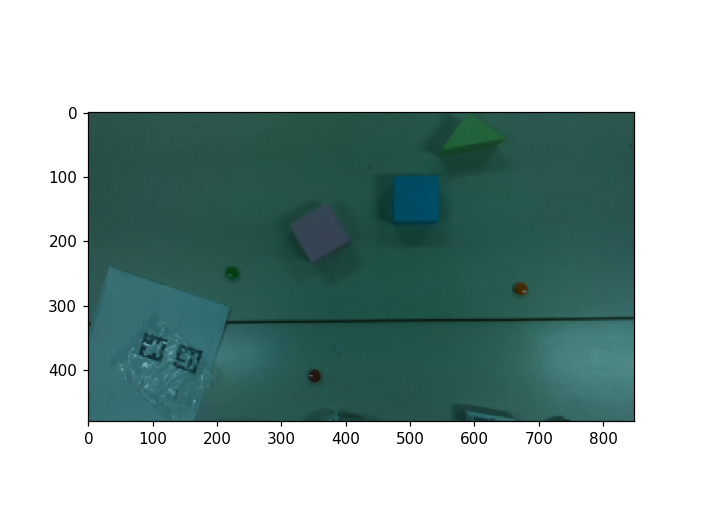

In [132]:
%matplotlib notebook
color, depth = get_view(ROBOT_INIT_POS, show_img=True)

In [134]:
goal_pixel = np.array([347, 411])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)

goal_position = T_base_to_initeef.dot(T_eef_to_rs.dot(np.concatenate([p_rs_to_goal, [1]])))[:3]
print(goal_position)

[-0.08155289  0.17227832  0.65000004]
[ 0.13112574 -0.21318816 -0.01575098]


In [137]:
def move_to_pixel(depth, goal_pixel):
    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    print(p_rs_to_goal)
    
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)
    T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))    
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    print(goal_position)
    _ = get_view(goal_position)

In [139]:
goal_pixel = np.array([347, 411])
move_to_pixel(depth, goal_pixel)

[-0.08155289  0.17227832  0.65000004]
[ 0.13112574 -0.21318816  0.2       ]
